In [84]:
from tvtk.api  import tvtk
import xarray
import numpy as np
import pandas as pd
from mayavi import mlab

In [95]:
ds = xarray.open_dataset('/Users/baart_f/data/odv/SDN_MedSea_Clim.nc')
ds = ds.isel(time=1)
arr = np.squeeze(ds.Temperature.values)
arr = np.ma.masked_invalid(arr)
arr = arr.filled(0)
arr.shape, np.nanmin(arr),  np.nanmax(arr)


((33, 129, 367), 0.0, 17.782095)

In [121]:
iso = mlab.contour3d(arr,  contours=[10.0, 15])

In [126]:
contour = iso.contour.outputs[0].output  #  .contour.outputs[0].output.print_traits()

In [127]:
contour.print_traits()

_in_set:                   0
_vtk_obj:                  (vtkCommonDataModelPython.vtkPolyData)0x14be9ab28
actual_memory_size:        10471
bounds:                    (4.696437835693359, 33.0,...1.0, 365.29974365234375)
cell_data:                 <tvtk.tvtk_classes.cell_d...a object at 0x1522148e0>
cell_ghost_array:          None
center:                    (18.84821891784668, 66.29...721, 183.14987182617188)
class_name:                'vtkPolyData'
data_object_type:          0
data_released:             0
debug:                     False
debug_:                    0
extent_type:               0
field_data:                <tvtk.tvtk_classes.field_...a object at 0x152214938>
ghost_level:               0
global_release_data_flag:  0
global_release_data_flag_: 0
global_warning_display:    1
global_warning_display_:   1
information:               <tvtk.tvtk_classes.inform...n object at 0x152214938>
length:                    386.32171901830526
lines:                     <tvtk.tvtk_classes.ce

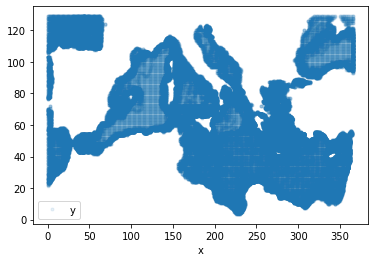

In [128]:
df =  pd.DataFrame(contour.points, columns=['z', 'y', 'x'])
df.plot('x', 'y', style='.', alpha=0.1)

In [129]:
writer = tvtk.PLYWriter(file_name='polydata.ply')

In [130]:
writer.add_input_data_object(contour)

In [133]:
writer.update()
writer.update_data_object()

In [134]:
writer.write()

1

In [ ]:
writer